<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from keras.layers import Input, TimeDistributed
from keras.layers import LSTM
from keras.models import Model

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob


from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import itertools

import keras
from keras.utils.np_utils import to_categorical  # use for converting labels to one-hot-encoding
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization  import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [3]:
images_df = pd.read_csv("/Users/harit/Desktop/drowsiness_data/77k_trial_2.csv")
images_df.head()


,id,image_id,label
0,0,drowsy0,0
1,1,drowsy1,0
2,2,drowsy2,0
3,3,drowsy3,0
4,4,drowsy4,0


In [4]:
path  = []
count=0

for i in images_df['id']:
    if i < 40309:
        path.append("/Users/harit/test_data/drowsy"+str(i)+".jpg")
    else:
        path.append("/Users/harit/test_data/vigilant"+str(i)+".jpg")
    while i > 85441:
        break
        
print(len(path))
images_df['path'] = path
images_df = shuffle(images_df)

85442


In [5]:

images_dict = {
    '0': 'Drowsy',
    '1': 'Vigilant'}

In [6]:
import cv2
#from tqdm import tqdm
def Dataset_loader():
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in images_df['path']:
        img = read(IMAGE_NAME)
        img = cv2.resize(img, (100,75))
        IMG.append(img)
    return IMG
images_df['image'] = Dataset_loader()

In [7]:
x = images_df['image']
y = images_df['label']

In [8]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(x, y, test_size=0.30,random_state=1234)


In [9]:
x_train = np.array(x_train_o.tolist())
x_test = np.array(x_test_o.tolist())

In [21]:
y_train = to_categorical(y_train_o, num_classes = 10)
y_test = to_categorical(y_test_o, num_classes = 10)

In [11]:
print(x_train.shape)
print(x_train[0].shape)

(59809, 75, 100, 3)
(75, 100, 3)


In [12]:
x_train=x_train.reshape(x_train.shape[0],100,75,3)
x_test=x_test.reshape(x_test.shape[0],100,75,3)

In [13]:
print(x_train.shape)

(59809, 100, 75, 3)


In [31]:
batch_size=2000
num_classes=10
epochs=1 
row_hidden=10
col_hidden=10


In [16]:
y_train=keras.utils.to_categorical(y_train,num_classes)
y_test=keras.utils.to_categorical(y_test,num_classes)
row,col,pixel=x_train.shape[1:]

#4d input
x=Input(shape=(row,col,pixel))

In [17]:
encoded_rows=TimeDistributed(LSTM(row_hidden))(x)

#encoded colomns

encoded_colomns=LSTM(col_hidden)(encoded_rows)

In [18]:
prediction=Dense(num_classes,activation='softmax')(encoded_colomns)
model=Model(x,prediction)
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [32]:
#training
result=model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_test,y_test))

Train on 53828 samples, validate on 25633 samples
Epoch 1/1
53828/53828 [==============================] - 1540s 29ms/step - loss: 1.6267 - accuracy: 0.5358 - val_loss: 1.4181 - val_accuracy: 0.5280


In [23]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [24]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("detection_model_24.h5")

5981/5981 [==============================] - 11s 2ms/step
Validation: accuracy = 0.539876  ;  loss_v = 1.814104
Test: accuracy = 0.537588  ;  loss = 1.814634


In [25]:
# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

In [26]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

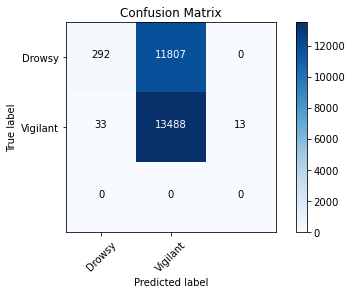

In [27]:
# plot the confusion matrix
cm_plot_labels = ['Drowsy', 'Vigilant']

plot_confusion_matrix(confusion_mtx, cm_plot_labels, title='Confusion Matrix')
#plot_confusion_matrix(confusion_mtx, classes = range(7))